In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import helper
import metrics
import _init_paths
import torch
import torch.utils.data
from opts import opts
#from lib.models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
#from trains.train_factory import train_factory
from pytorch_unet_center_wh import train_model
import unet_models
import os,sys
#import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import helper
#import simulation
from tqdm import tqdm
import time
import copy
from models.data_parallel import DataParallel
import numpy as np
import torch
import metrics
from metrics import MetricsCollection
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
#from test_model import test
from scipy.ndimage.measurements import label
import shutil

In [2]:
from pycocotools.coco import COCO


In [9]:
class opts(object):
  def __init__(self):
    self.seed = 327
    self.dataset = 'shape'
    self.task = 'ctdet'
    self.device = 'cuda'
    self.shape_param = ''
    self.shape_param_value = ''
    self.data_dir = '/home/ali/CenterNet/data'
    self.batch_size = 10
    self.master_batch_size = -1
    self.no_color_aug = True
    self.num_workers = 4
    self.keep_res = False
    self.pad = 127
    self.not_rand_crop = True
    self.scale =0.4
    self.shift =0.1
    self.flip = 0.5
    self.down_ratio = 1
    self.mse_loss = True
    self.gpus = '0,1'
    #self.gpus_str = '0'
    self.input_res = -1
    self.input_h = 128#-1
    self.input_w = 128#-1
    self.cat_spec_wh = True
    self.not_reg_offset = True
    self.reg_offset = not self.not_reg_offset
    self.save_dir = '/home/ali/CenterNet/src/experimets_log'
    self.debug_dir = '/home/ali/CenterNet/src/experimets_log'
    self.trainval = True
    self.test_scales = '1'
    self.exp_id = 'default'
    self.debug = 0
    self.debugger_theme = 'white'
    self.fix_res = True
    self.flip_test =True
    self.resume = False
    self.last_model = ''
    self.checkpoint_interval = 50
    self.epochs = 100
    self.start_epoch = 0
    
    #self.root_dir = os.path.join(os.path.dirname(__file__), '..', '..')
    #self.data_dir = os.path.join(self.root_dir, 'data')
    
opt = opts()
    

In [5]:
def train_model(model, optimizer, lr_scheduler, data_loader, device, max_epochs): #loaders
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    has_waited = 0
    stop_training = False
    earlystop_patience = 50

    epoch_metrics = MetricsCollection()

    for epoch in range(opt.start_epoch, max_epochs):
        print('Epoch {}/{}'.format(epoch, max_epochs - 1))
        for phase in ['train', 'val']:
            model.train()
        # Each epoch has a training and validation phase

            batch_metrics = MetricsCollection()

            for ind, (img_id, batch) in enumerate(data_loader): #data_loader
                for k in batch:
                    if k != 'meta':
                        batch[k] = batch[k].to(device=device, non_blocking=True) 
                inputs,class_masks,center_masks,width_masks,height_masks = batch['input'],batch['gt_segmap'], batch['gt_ctmap'], batch['gt_widmap'], batch['gt_heimap'] # loss_stats
                
                output, losses = model(inputs, class_masks, center_masks, width_masks, height_masks) #batch
                loss = losses['loss']
                loss = loss.mean()
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                for k, v in losses.items():
                    batch_metrics.add(phase, k, v.item())
                    
            output_str= ''
            for key, meter in batch_metrics[phase].items():
                epoch_metrics.add(phase, key, meter.avg)
                if phase=='train':
                    output_str+= '{}_{}'.format(phase, key)
                    output_str+= ':'
                    output_str+=str(meter.avg)
                    output_str+= ' '
            print(output_str)
            file_name = os.path.join(opt.save_dir, 'log.txt')
            if (os.path.exists(file_name)):
                with open(file_name, 'a') as log_file:
                    log_file.write(output_str+ '\n')
            else:
                with open(file_name, 'wt') as log_file:
                    log_file.write(output_str+'\n')
            if  phase == 'val': # (epoch% 10== 0 and epoch > 0): # phase == 'val' and
                model.eval()
                # monitor the val metrics
                best_epoch_index = epoch_metrics['val']['loss'].best()[1]
                #print(best_epoch_index, '-', epoch - opt.start_epoch)
                if best_epoch_index == epoch - opt.start_epoch: #epoch:
                    has_waited = 1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print("Saving the best model state dict")
                else:
                    if has_waited >= earlystop_patience:
                        print("** Early stop in training: {} waits **".format(has_waited))
                        stop_training = True

                    has_waited += 1
                if type(lr_scheduler) is torch.optim.lr_scheduler.ReduceLROnPlateau:
                    lr_scheduler.step(epoch_metrics['val']['loss'].value)
                else:
                    lr_scheduler.step()
                    
            if epoch % opt.checkpoint_interval == 0 and epoch > 0 : #and epoch > 0
                    save_checkpoint({
                    'epoch': epoch + 1,
                    #'arch': args.arch,
                    'state_dict': model.state_dict(),
                    #'best_prec1': best_prec1,
                    'optimizer' : optimizer.state_dict(),
                        }, 
                            False, f'./checkpoints/model_last_{epoch}.pth')
                
                    #model.load_state_dict(best_model_wts)
                    #torch.save(model.state_dict(), f'./checkpoints/model_last_{epoch}.pth')              

        #print()  # end of epoch
        if stop_training:
            break

    #time_elapsed = time.time() - since
    #print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    #load best model weights
    model.load_state_dict(best_model_wts)
    save_checkpoint({
            'epoch': epoch + 1,
            #'arch': args.arch,
            'state_dict': model.state_dict(),
            #'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
        }, True)
    
    #torch.save(model.state_dict(), './checkpoints/model_last.pth')    
    #torch.save(model, './checkpoints/model_last.pth')
    print ('New model saved!')
    return model



In [90]:
def save_checkpoint(state, is_best, filename='./checkpoints/model_best.pth'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, './checkpoints/model_best_x.pth')

In [91]:
def set_device(gpus, chunk_sizes, device, model, optimizer):
    if len(gpus) > 1:
      self.model_with_loss = DataParallel(
        self.model_with_loss, device_ids=gpus, 
        chunk_sizes=chunk_sizes).to(device)
    else:
      self.model_with_loss = self.model_with_loss.to(device)
    
    for state in optimizer.state.values():
      for k, v in state.items():
        if isinstance(v, torch.Tensor):
          state[k] = v.to(device=device, non_blocking=True)

In [92]:

def main():
  
  opt.gpus = [int(gpu) for gpu in opt.gpus.split(',')]
  opt.gpus = [i for i in range(len(opt.gpus))] if opt.gpus[0] >=0 else [-1]
  
  if opt.master_batch_size == -1:
    opt.master_batch_size = opt.batch_size // len(opt.gpus)
  rest_batch_size = (opt.batch_size - opt.master_batch_size)
  opt.chunk_sizes = [opt.master_batch_size]
  for i in range(len(opt.gpus) - 1):
    slave_chunk_size = rest_batch_size // (len(opt.gpus) - 1)
    if i < rest_batch_size % (len(opt.gpus) - 1):
      slave_chunk_size += 1
    opt.chunk_sizes.append(slave_chunk_size)  
  
  device = torch.device('cuda' if opt.gpus[0] >= 0 else 'cpu')  
  #set_device(opt.gpus, opt.chunk_sizes, device)      
  torch.manual_seed(opt.seed)
  
  Dataset = get_dataset(opt.dataset, opt.task)
  
  #val_loader = torch.utils.data.DataLoader(
  #    Dataset(opt, 'val'), 
  #    batch_size=1, 
  #    shuffle=False,
  #    num_workers=1,
  #    pin_memory=True)
      


  train_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=False,
      drop_last=True
  )
  #Mehdi
  ###############

  import models

  #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  num_class = Dataset.num_classes #6
  lr_factor = 0.1
  lr_patience = 1
  lr = 1e-4
  if(len (opt.gpus)>1):
        modelunet= DataParallel(
        unet_models.WidthHeightUNet(num_class), device_ids=opt.gpus, 
        chunk_sizes=opt.chunk_sizes).to(device)
        
  else:
        modelunet = unet_models.WidthHeightUNet(num_class).to(device)

  optimizer = torch.optim.Adam(modelunet.parameters(), lr=lr)
  lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                            factor=lr_factor,
                                                          patience=lr_patience,
                                                            verbose=True)
  for state in optimizer.state.values():
      for k, v in state.items():
        if isinstance(v, torch.Tensor):
          state[k] = v.to(device=device, non_blocking=True)
        
  if opt.resume:
        if os.path.isfile(opt.last_model):
            print("=> loading checkpoint '{}'".format(opt.last_model))
            checkpoint = torch.load(opt.last_model)
            opt.start_epoch = checkpoint['epoch']
            #best_prec1 = checkpoint['best_prec1']
            modelunet.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(opt.last_model, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(opt.resume))    
   # modelunet.load_state_dict(torch.load(opt.last_model))
        
  model = train_model(modelunet, optimizer, lr_scheduler, train_loader,device, max_epochs = opt.epochs)
  return model  

In [93]:
opt.resume = False
opt.last_model = './checkpoints/model_best.pth'
opt.epochs =  170
#opt.start_epoch = 0
#opt.checkpoint_interval= 50
trained_model = main()


==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=12.99s)
creating index...
index created!
Loaded train 118287 samples
Epoch 0/169


ValueError: only one element tensors can be converted to Python scalars

In [14]:
m = torch.load('./model_last(multicombined8000-500ep).pth')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
modelunet = unet_models.WidthHeightUNet(5).to(device)  #num_class   

In [7]:
import torch
print (torch.__version__)

1.1.0


In [17]:
# !conda info --envs
# !pwd
m

WidthHeightUNet(
  (base_model): ResNetUNet(
    (base_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Ba

In [15]:
modelunet.load_state_dict(m['state_dict'])



TypeError: 'WidthHeightUNet' object is not subscriptable

In [18]:

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    #inp = np.clip(inp, 0, 1)
    #inp = (inp * 255).astype(np.uint8) 
    
    return inp

In [21]:
#trained_model = torch.load('./checkpoints/model_best.pth')
#trained_model=modelunet. ['state_dict'][0]

import math
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage.measurements import label  
import cv2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_class = n_class = 5

    
Dataset = get_dataset(opt.dataset, opt.task)
  
val_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=1, 
      shuffle=True,
      num_workers=1,
      pin_memory=True)

model=modelunet#trained_model  
    
model.eval()   # Set model to evaluate mode


==> initializing shapes train data.
loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: '/home/ali/CenterNet/data/shapes/annotations/instances_shape__2019.json'

In [20]:

#test_dataset = SimDataset(1, n_class, transform = trans)
#test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
        
#batch  = next(iter(val_loader))

img_id, batch = next(iter (val_loader))
for k in batch:
    if k != 'meta':
        batch[k] = batch[k].to(device=device, non_blocking=True)
inputs, labels_mask, labels_center, labels_width, labels_height  =batch['input'],batch['gt_segmap'], batch['gt_ctmap'], batch['gt_widmap'], batch['gt_heimap']
pred = model(inputs, labels_mask, labels_center, labels_width, labels_height )
pred = pred[0]



#inputs = inputs.to(device)
# labels_mask = labels_mask.to(device)
# labels_center = labels_center.to(device)



# Change channel-order and make 3 channels for matplot
#input_images_rgb = [reverse_transform(x)/255 for x in inputs.cpu()]


# Map each channel (i.e. class) to each color
#target_masks_rgb = [helper.masks_to_colorimg(x/255, n_class) for x in labels_mask]

# Map each channel (i.e. class) to each color
#target_centers_rgb = [helper.masks_to_colorimg(x/255, n_class) for x in labels_center]

for i in [pred]:
    pred_masks = i['class_masks'].data.cpu().numpy()
    pred_centers = i['center_masks'].data.cpu().numpy()
    pred_widths = i['width_masks'].data.cpu().numpy()
    pred_heights = i['height_masks'].data.cpu().numpy()

    mask = pred_centers.copy() 
    mask[mask<0]=0
    mask[mask>0]=1
    
    #import pdb; pdb.set_trace()
    #pred_masks_rgb = [helper.masks_to_colorimg(x, n_class) for x in pred_masks]
    #pred_centers_rgb = [helper.masks_to_colorimg(x, n_class) for x in mask] # pred_centers
    #pred_widths_rgb = [helper.masks_to_colorimg(x, n_class) for x in pred_widths * mask]
    #pred_heights_rgb = [helper.masks_to_colorimg(x, n_class) for x in pred_heights * mask]



# Left: Input image, Right: Target mask (Ground-truth)
#helper.plot_side_by_side([input_images_rgb, target_masks_rgb, target_centers_rgb, pred_masks_rgb, pred_centers_rgb, pred_widths_rgb, pred_heights_rgb])


# -------

inp = np.copy(inputs.cpu())
img = np.copy(inp[0])
# img = img.reshape((192,192,3))
img = np.transpose(img,[1,2,0])/255
# img = img(:,:,[0])

#org = np.copy(org_img.cpu())
#orgim = np.copy(org[0])
# img = img.reshape((192,192,3))
#orgim = np.transpose(orgim,[1,2,0])/255


f, plots = plt.subplots(n_class, 5, sharex='all', sharey='all', figsize=(4 * 10, 4 * 10)) #n_class

ret = {}
ret['results'] = {}
for i in range(1,n_class+1):
    ret['results'][i] = []  
count_obj = 0
for i in range(n_class):
    a2 = np.copy(pred_centers[0,i,:,:])
    a2[a2<0]=0
    a2[a2>0]=1
    plots[i,0].imshow(a2)

    a4 = np.copy(pred_widths[0,i,:,:])     
    a4 = a4*a2 #.numpy()
    plots[i,1].imshow(a4)


    a5 = np.copy(pred_heights[0,i,:,:])     
    a5 = a5*a2 #.numpy()    

# finding connected components
    from scipy.ndimage.measurements import label  
    structure = np.ones((3, 3), dtype=np.int)
    labeled, ncomponents = label(a4, structure)
    indices = np.indices(a4.shape).T[:,:,[1, 0]]

    ax = plots[i,2] #plt.subplots(1)
    ax.imshow(img)
    coords = []
    
    for c in range(ncomponents):
        a = indices[labeled == c+1]
        x, y = (np.min(a[:,0]) + np.max(a[:,0]))//2, (np.min(a[:,1]) + np.max(a[:,1]))//2
        w, h = int(a4[x,y])+1, int(a5[x,y])+1
        coords.append( (x, y , w, h) )    
        rect = patches.Rectangle((y-w//2, x-h//2), w, h, linewidth=1, edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    
    print((coords))
    if(len(coords)!=0):
        count_obj+=1
    tt = []
    for u in range(ncomponents):
        x, y = coords[u][:2]
        confidences = torch.softmax(torch.tensor(pred_centers[0,:,x,y]), dim=0)
        tt += [list(coords[u]) + [confidences[i].tolist()]]
    tt = np.array(tt, np.float32)
    
    ret['results'][i] = tt
    
    #semantic_mask = np.zeros(pred_masks.shape[2:])
    pred_masks_class = pred_masks[0,i,...]
    pred_masks_class[pred_masks_class<0] = 0 #pred_masks_class
    pred_masks_class[pred_masks_class>0] = 1

    #for box in coords:
    #    x, y, w, h = box
    #    w , h = w//2+1, h//2+1
    #    semantic_mask[y-h:y+h, x-w:x+w]  = 1
    plots[i,3].imshow(pred_masks_class) # * semantic_mask )  


    instance_mask = np.zeros(pred_masks.shape[2:])
    pred_masks_class = pred_masks[0,i,...]
    pred_masks_class[pred_masks_class<0] = 0
    pred_masks_class[pred_masks_class>0] = 1
    xx = np.zeros(pred_masks.shape[2:], dtype=np.int)
    cc = 1
    
    im_w, im_h = pred_masks.shape[2:]
    
    for box in coords:
        x, y, w, h = box
        w , h = w//2+5, h//2+5
        x1, x2, y1, y2 = np.max([x-w, 0]), np.min([x+w, im_w]), np.max ([y-h, 0 ]), np.min([y+h, im_h])
        instance_mask = np.zeros(pred_masks.shape[2:])
        instance_mask[x1:x2, y1:y2]  = 1
        mm = np.zeros(pred_masks.shape[2:], dtype=np.int)
        mm = pred_masks_class.astype(int) * instance_mask.astype(int) 
        mm = mm * cc
        xx = xx + mm
        xx[xx>cc] = cc
        cc += 1

        
        
#     xx = np.reshape(xx, [1,xx.shape[0], xx.shape[1]])
#     xx = xx[0,0,:,:]
    xx = xx.astype(int)
    #print(np.min(xx), np.max(xx))
    plots[i,4].imshow(xx)
    #plots[i,4].imshow(helper.masks_to_colorimg3(xx))
print (count_obj)

NameError: name 'val_loader' is not defined

In [ ]:

def get_res(pred,n_class):
    
    for i in [pred]:
        pred_masks = i['class_masks'].data.cpu().numpy()
        pred_centers = i['center_masks'].data.cpu().numpy()
        pred_widths = i['width_masks'].data.cpu().numpy()
        pred_heights = i['height_masks'].data.cpu().numpy()
    
    ret = {}
    ret['results'] = {}
    for i in range(1,n_class+1):
        ret['results'][i] = []  

    for i in range(n_class):
        a2 = np.copy(pred_centers[0,i,:,:])
        a2[a2<0]=0
        a2[a2>0]=1
    
        a4 = np.copy(pred_widths[0,i,:,:])     
        a4 = a4*a2 #.numpy()
   

        a5 = np.copy(pred_heights[0,i,:,:])     
        a5 = a5*a2 #.numpy()    
      
        structure = np.ones((3, 3), dtype=np.int)
        labeled, ncomponents = label(a4, structure)
        indices = np.indices(a4.shape).T[:,:,[1, 0]]

    
        coords = []
        for c in range(ncomponents):
            a = indices[labeled == c+1]
            x, y = (np.min(a[:,0]) + np.max(a[:,0]))//2, (np.min(a[:,1]) + np.max(a[:,1]))//2
            w, h = int(a4[x,y])+1, int(a5[x,y])+1
            coords.append( (x,y,w,h) )
            
        
        #import pdb
        #pdb.set_trace()
        tt = []
        for u in range(ncomponents):
            #print (coords[u],'n_component')
            x, y, w, h = coords[u]
            confidences = torch.softmax(torch.tensor(pred_centers[0,:,x,y]), dim=0)
            tt += [list((y-w/2 , x-h/2, y+w/2, x+h/2 )) + [confidences[i].tolist()]]
        tt = np.array(tt, np.float32)
    
        ret['results'][i+1] = tt
    return ret


In [ ]:
n_class = 5  
Dataset = get_dataset(opt.dataset, opt.task)

val_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=1,#opt.batch_size, 
      shuffle=True,
      num_workers=1,#opt.num_workers,
      pin_memory=True,
      drop_last=True
)
  
#val_loader = torch.utils.data.DataLoader(
#      Dataset(opt, 'val'), 
#      batch_size=1, 
#      shuffle=True,
#      num_workers=1,
#      pin_memory=True)

model=trained_model  
    
model.eval()   # Set model to evaluate mode
results= {}
for ind, (img_id, batch) in enumerate(val_loader):
   #print(img_id)
   #import pdb; pdb.set_trace()
   # import ipdb; ipdb.set_trace()
    for k in batch:
        if k != 'meta':
            batch[k] = batch[k].to(device=device, non_blocking=True)
    inputs, labels_mask, labels_center, labels_width, labels_height  =batch['input'],batch['gt_segmap'], batch['gt_ctmap'], batch['gt_widmap'], batch['gt_heimap']
    pred = model(inputs, labels_mask, labels_center, labels_width, labels_height )
    pred = pred[0] 
    #ret = detector.run(pre_processed_images)
 
    ret = get_res(pred, n_class)

    results[img_id.numpy().astype(np.int32)[0]] = ret['results']
    #Bar.suffix = '[{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(ind, num_iters, total=bar.elapsed_td, eta=bar.eta_td)
    #for t in avg_time_stats:
    #    avg_time_stats[t].update(ret[t])
    #     Bar.suffix = Bar.suffix + '|{} {tm.val:.3f}s ({tm.avg:.3f}s) '.format(
    #   t, tm = avg_time_stats[t])
    #bar.next()
#bar.finish()
#Dataset = get_dataset(opt.dataset, opt.task)
dataset = Dataset(opt,'test')
dataset.run_eval(results, opt.save_dir)
#dataset.run_eval(results, opt.save_dir)

In [15]:
labels_mask.shape

torch.Size([1, 20, 128, 128])

In [43]:
class_name = [
      '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
      'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
      'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
      'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
      'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
      'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
      'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
      'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
      'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
      'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
      'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
      'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
      'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [16]:
len(class_name)

NameError: name 'class_name' is not defined

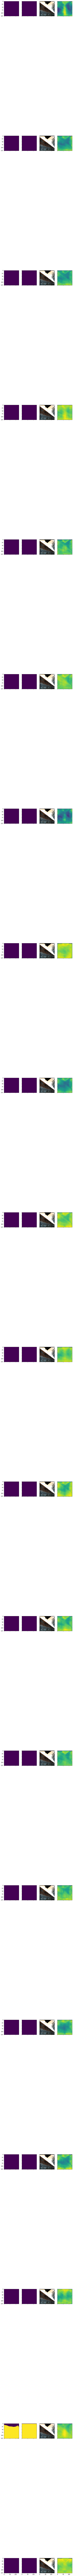

In [15]:
#labels_mask = labels_mask.to(device)
f, plots = plt.subplots(n_class,4 , sharex='all', sharey='all', figsize=(1 * 10, 40 * 10))
for i in range(n_class):
   # plt.figure()
    plots[i,0].imshow(pred_masks[0,i])
    plots[i,1].imshow(labels_mask[0,i].cpu())
    plots[i,2].imshow(img)
    #plots[i,1].imshow(labels_center[0,i])
    #plots[2,i].imshow(labels_width[0,i])
    #plots[i,1].imshow(img)
    plots[i,3].imshow(pred_centers[0,i])
#    xx = pred_centers[0,i]
#    xx[xx>0] = 1
#    xx[xx<0] = 0
    #plots[4,i].imshow(xx)

    #plots[5,i].imshow(pred_widths[0,i])
    

    

    


In [ ]:
Dataset = get_dataset(opt.dataset, opt.task)
dataset = Dataset(opt,'test')
dataset.run_eval(results, opt.save_dir)
#len(results)

In [ ]:
np.sort(pred_centers[-1,...][4].ravel())

In [ ]:
#plt.imshow(pred_masks[0].transpose((1, 2, 0)))
import math
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage.measurements import label  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_class = 3
n_class=3
    
Dataset = get_dataset(opt.dataset, opt.task)
  
val_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'val'), 
      batch_size=1, 
      shuffle=True,
      num_workers=1,
      pin_memory=True)
batch  = next(iter(val_loader))
for k in batch:
    if k != 'meta':
        batch[k] = batch[k].to(device=device, non_blocking=True)
inputs, labels_mask, labels_center, labels_width, labels_height  =batch['input'],batch['gt_segmap'], batch['gt_ctmap'], batch['gt_widmap'], batch['gt_heimap']

k =1
plt.imshow(pred_masks[0,k])

In [ ]:
orgim.shape

In [ ]:
k = 4
plt.imshow(labels_mask[0,k])

In [ ]:
k=3
plt.imshow(labels_height[0,k])


In [ ]:
k = 3
plt.imshow(labels_width[0,k])

In [ ]:
k = 4
plt.imshow(labels_center[0,k])

In [ ]:
plt.figure()
#plt.imshow(reverse_transform(inputs[0].cpu()))
#plt.imshow(reverse_transform(labels_mask[0].cpu()))
#plt.imshow(reverse_transform(labels_center[0].cpu()))
#plt.imshow(reverse_transform(labels_width[0].cpu()))
#plt.imshow(reverse_transform(labels_height[0].cpu()))
plt.imshow(inputs[0].cpu().numpy().transpose((1, 2, 0))/255) #.dtype

In [ ]:
k = 4
plt.imshow(pred_widths[0,k])

In [ ]:
l.shape

In [ ]:
plt.imshow(pred_masks[0,4])